# Deep Residual Learning for Image Recognition: CIFAR-10 

This notebook provides a PyTorch implementation of *Deep Residual Learning for Image Recogniton* by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Han Sun which achived state of the art in 2015 by winning the ILSVRC and COCO challenges.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

from resnet import ResNet
from data_loader import get_data_loaders, plot_images
from utils import calculate_normalisation_params
from train import train


import warnings
warnings.filterwarnings('ignore')

In [3]:
# GLOBALS
# -----------------------

# data_dir = 'data/cifar10'
data_dir = 'data/hiragana'
batch_size = 128


## Data augmentation: Training set

data/hiragana
full_data: 80000
train_dataset: 64000
test_dataset:16000


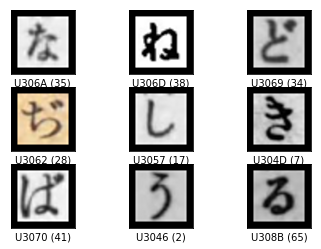

torch.Size([128, 3, 40, 40])


In [4]:
# VISUALISE
# -----------------------

# Load data without normalisations

train_transform = transforms.Compose([
    transforms.Resize((32,32)), # For Hiragana
    # 4 pixels are padded on each side, 
    transforms.Pad(4),
    # a 32×32 crop is randomly sampled from the 
    # padded image or its horizontal flip.
    # Comment out for Hiragana
    # transforms.RandomHorizontalFlip(0.5),
    # transforms.RandomCrop(32),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((32,32)), # For Hiragana
    # For testing, we only evaluate the single 
    # view of the original 32×32 image.
    transforms.ToTensor()
])

train_loader, test_loader = get_data_loaders(data_dir,
                                             batch_size,
                                             train_transform,
                                             test_transform,
                                             shuffle=True,
                                             num_workers=4,
                                             pin_memory=True)


# Training images
data_iter = iter(train_loader)
images, labels = data_iter.next()
X = images.numpy().transpose([0, 2, 3, 1])
plot_images(X, labels)
print(images.shape)

The training set consists of 50,000 32x32 pixel images. These are padded with 4 pixels on each side, before a crop is randomly sampled from the padded image or its horziontal flip. 

The authors cite C.-Y. Lee, S. Xie, P. Gallagher, Z. Zhang, and Z. Tu. Deeply-supervised nets. arXiv:1409.5185, 2014. This paper suggests that 'corner cropping' should be used which could be interpretted one of two ways:

1. There are five possible crops for each image, centre and then four further crops with the crop placed tightly in each corner. This equates to `torchvision.transforms.FiveCrop()` in PyTorch.
2. The crop position is randomly selected from any possible position within the bounds of the padded image. Equivalent to `torchvision.transforms.RandomCrop()` in PyTorch.

The intended implementation seem ambiguous to me, so I implemented the latter here largely for simplicity.

## Data augmentation: Test set

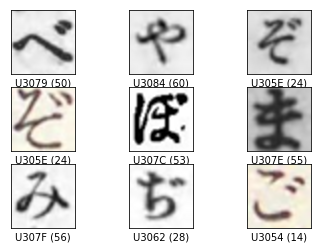

torch.Size([128, 3, 32, 32])


In [5]:
# Test images
data_iter = iter(test_loader)
images, labels = data_iter.next()
X = images.numpy().transpose([0, 2, 3, 1])
plot_images(X, labels)
print(images.shape)

**There** are 10,000 images in the test set. These are not transformed.

## Calculate normalisation parameters

The authors don't explicitly state if the images are normalised prior to training, however the paper referenced on preprocessing (C.-Y. Lee, S. Xie, P. Gallagher, Z. Zhang, and Z. Tu. Deeply-supervised nets. arXiv:1409.5185, 2014) notes that normalisation is used. 

I was unsure if the mean and standard deviation of the dataset should be calculated before or after augmentation for this purpose. It is also unclear if these calcualations should be done across the training and test set combined, or only the training set.

Her I've used the pre-transform training and test set combined.

In [6]:
# NORMALIZATION
# -----------------------
# Calculate the mean and standard deviation of each channel
# for all observations in training and test datasets. The
# results can then be used for normalisation

# Load data without transforms

train_transform = transforms.Compose([
    transforms.Resize((32,32)), # For Hiragana
    # 4 pixels are padded on each side, 
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((32,32)), # For Hiragana
    # For testing, we only evaluate the single 
    # view of the original 32×32 image.
    transforms.ToTensor()
])

train_loader, test_loader = get_data_loaders(data_dir,
                                             batch_size,
                                             train_transform,
                                             test_transform,
                                             shuffle=True,
                                             num_workers=4,
                                             pin_memory=True)


# Takes a while to run so I've hardcoded results below

means, stds = calculate_normalisation_params(train_loader, test_loader)
print(f'means: {means}')
print(f'stds: {stds}')

data/hiragana
full_data: 80000
train_dataset: 64000
test_dataset:16000
means: [0.7480539406810097, 0.7480233994039425, 0.7479885668196091]
stds: [0.2609100478283504, 0.2609037458344347, 0.26091227744470497]


## Preprocessing

Here we finalise data augmentation and normalisation parameters ahead of training.

In [7]:
# SET FINAL TRANSFORMS WITH NORMALISATION

# [x] simple data augmentation in [24]
# [x] 4 pixels are padded on each side, 
# [x] and a 32×32 crop is randomly sampled from the padded image or its horizontal flip.
# [x] For testing, we only evaluate the single view of the original 32×32 image.


# Normalisation parameters fo CIFAR10
means = [0.4918687901200927, 0.49185976472299225, 0.4918583862227116]
stds  = [0.24697121702736, 0.24696766978537033, 0.2469719877121087]

normalize = transforms.Normalize(
    mean=means,
    std=stds,
)

train_transform = transforms.Compose([
    transforms.Resize((32,32)), # For Hiragana
    # 4 pixels are padded on each side, 
    transforms.Pad(4),
    # Comment out for Hiragana
    # a 32×32 crop is randomly sampled from the 
    # padded image or its horizontal flip.
    # transforms.RandomHorizontalFlip(0.5),
    # transforms.RandomCrop(32),
    transforms.ToTensor(),
    normalize
])

test_transform = transforms.Compose([
    transforms.Resize((32,32)), # For Hiragana
    # For testing, we only evaluate the single 
    # view of the original 32×32 image.
    transforms.ToTensor(),
    normalize
])

Notes:

- Note: downsampling with stride 2 results in uneven convolution, e.g. W_out is 16.5. Why didn't the authors use Maxpooling, would have been neater.

## Training

The authors report their results in term of training iterations. I've assumed an iteration here means a forwards and backwards pass of a batch of 128 observations through the entire network.

It seems more convenient to work in epochs in PyTorch, so here I calculate the integer number of iterations per epoch for later conversions. The results is 391 iterations per epoch. An epoch is a forwards and backwards pass for all observations in the training set.

In [8]:
# How many iterations in an epoch?

iterations = 0
for i, data in enumerate(train_loader, 0):
    iterations +=1
print(iterations)

500


### Hyperparameters

Set the hyperparameters as described by the authors, with iterations converted to epochs where appropriate.

In [9]:
# TRAINING PARAMETERS
# -------------------------

# Authors cite 64k iterations
# 64000/391 = 164
epochs = 164

# OPTIMISER PARAMETERS
lr = 0.1 # authors cite 0.1
momentum = 0.9
weight_decay = 0.0001 

# LEARNING RATE ADJUSTMENT
# Reduce learning rate at iterations 
# 32k and 48k. Convert to epochs:
# e.g. iterations / (n_observations/batch_size) 
# 32000/391 = 82
# 48000/391 = 123
milestones = [82, 123]
# Divide learning rate by 10 at each milestone
gamma = 0.1

### Plain nets

Run training loop for **'plain' convolutional networks** without shortcuts. Here we run for n={3, 5, 7,9} corresponding to networks of depth 20, 32, 44 and 64 layers. 

In [10]:
# TRAIN PLAIN NETs

# n determines network size as described in paper
# where total number of layers is (6*n)+2
ns = [3, 5, 7, 9]

# Train plainnets
for n in ns:
    print(f'MODEL SIZE: n={n}')
    # Reload data
    train_loader, test_loader = get_data_loaders(data_dir,
                                                 batch_size,
                                                 train_transform,
                                                 test_transform,
                                                 shuffle=True,
                                                 num_workers=4,
                                                 pin_memory=True)
    
    model = torch.nn.DataParallel(ResNet(n, shortcuts=False)) # modified from original
    criterion = torch.nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    results_file = f'results/plainnet{6*n+2}.csv'
    model_file = f'pretrained/plainnet{6*n+2}.pt'
    train(model, epochs, train_loader, test_loader, criterion, 
          optimizer, results_file, scheduler=scheduler, MODEL_PATH=model_file)

MODEL SIZE: n=3
data/hiragana
full_data: 80000
train_dataset: 64000
test_dataset:16000
cuda:0
Epoch 	Batch 	NLLLoss_Train
1 	50 	3.954
1 	100 	2.053
1 	150 	0.492
1 	200 	0.235
1 	250 	0.155
1 	300 	0.399
1 	350 	0.133
1 	400 	0.109
1 	450 	0.102
1 	500 	0.083
train_err: 0.02571875 test_err: 0.1814375
2 	50 	0.058
2 	100 	0.065
2 	150 	0.065
2 	200 	0.068
2 	250 	0.062
2 	300 	0.060
2 	350 	0.055
2 	400 	0.059
2 	450 	0.049
2 	500 	0.044
train_err: 0.01090625 test_err: 0.0995625
3 	50 	0.032
3 	100 	0.039
3 	150 	0.041
3 	200 	0.043
3 	250 	0.039
3 	300 	0.031
3 	350 	0.038
3 	400 	0.039
3 	450 	0.036
3 	500 	0.031
train_err: 0.008453125 test_err: 0.07675
4 	50 	0.025
4 	100 	0.020
4 	150 	0.025
4 	200 	0.031
4 	250 	0.020
4 	300 	0.022
4 	350 	0.036
4 	400 	0.026
4 	450 	0.020
4 	500 	0.020
train_err: 0.006171875 test_err: 0.0728125
5 	50 	0.019
5 	100 	0.022
5 	150 	0.017
5 	200 	0.016
5 	250 	0.014
5 	300 	0.018
5 	350 	0.024
5 	400 	0.025
5 	450 	0.023
5 	500 	0.021
train_err: 0.00

44 	50 	0.009
44 	100 	0.005
44 	150 	0.006
44 	200 	0.004
44 	250 	0.005
44 	300 	0.003
44 	350 	0.014
44 	400 	0.007
44 	450 	0.005
44 	500 	0.008
train_err: 0.001859375 test_err: 0.0116875
45 	50 	0.005
45 	100 	0.010
45 	150 	0.014
45 	200 	0.009
45 	250 	0.010
45 	300 	0.013
45 	350 	0.006
45 	400 	0.014
45 	450 	0.020
45 	500 	0.017
train_err: 0.0175 test_err: 0.0804375
46 	50 	0.008
46 	100 	0.006
46 	150 	0.008
46 	200 	0.012
46 	250 	0.008
46 	300 	0.008
46 	350 	0.007
46 	400 	0.016
46 	450 	0.012
46 	500 	0.007
train_err: 0.00578125 test_err: 0.03475
47 	50 	0.008
47 	100 	0.009
47 	150 	0.013
47 	200 	0.009
47 	250 	0.008
47 	300 	0.011
47 	350 	0.008
47 	400 	0.013
47 	450 	0.009
47 	500 	0.005
train_err: 0.016078125 test_err: 0.0115625
48 	50 	0.006
48 	100 	0.008
48 	150 	0.008
48 	200 	0.008
48 	250 	0.013
48 	300 	0.007
48 	350 	0.006
48 	400 	0.007
48 	450 	0.009
48 	500 	0.015
train_err: 0.005625 test_err: 0.0275625
49 	50 	0.018
49 	100 	0.011
49 	150 	0.014
49 	200

87 	50 	0.001
87 	100 	0.001
87 	150 	0.001
87 	200 	0.001
87 	250 	0.001
87 	300 	0.001
87 	350 	0.001
87 	400 	0.001
87 	450 	0.001
87 	500 	0.001
train_err: 3.125e-05 test_err: 0.0045
88 	50 	0.001
88 	100 	0.001
88 	150 	0.001
88 	200 	0.001
88 	250 	0.001
88 	300 	0.001
88 	350 	0.001
88 	400 	0.001
88 	450 	0.001
88 	500 	0.001
train_err: 3.125e-05 test_err: 0.00425
89 	50 	0.001
89 	100 	0.001
89 	150 	0.001
89 	200 	0.001
89 	250 	0.001
89 	300 	0.001
89 	350 	0.001
89 	400 	0.001
89 	450 	0.001
89 	500 	0.001
train_err: 3.125e-05 test_err: 0.0040625
90 	50 	0.001
90 	100 	0.001
90 	150 	0.001
90 	200 	0.001
90 	250 	0.001
90 	300 	0.001
90 	350 	0.001
90 	400 	0.001
90 	450 	0.001
90 	500 	0.001
train_err: 3.125e-05 test_err: 0.004
91 	50 	0.001
91 	100 	0.001
91 	150 	0.001
91 	200 	0.001
91 	250 	0.001
91 	300 	0.001
91 	350 	0.001
91 	400 	0.001
91 	450 	0.001
91 	500 	0.001
train_err: 3.125e-05 test_err: 0.0039375
92 	50 	0.001
92 	100 	0.001
92 	150 	0.001
92 	200 	0.001


129 	500 	0.001
train_err: 0.0 test_err: 0.0034375
130 	50 	0.001
130 	100 	0.001
130 	150 	0.001
130 	200 	0.001
130 	250 	0.001
130 	300 	0.001
130 	350 	0.001
130 	400 	0.001
130 	450 	0.001
130 	500 	0.001
train_err: 0.0 test_err: 0.00325
131 	50 	0.001
131 	100 	0.001
131 	150 	0.001
131 	200 	0.001
131 	250 	0.001
131 	300 	0.001
131 	350 	0.001
131 	400 	0.001
131 	450 	0.001
131 	500 	0.001
train_err: 0.0 test_err: 0.0033125
132 	50 	0.001
132 	100 	0.001
132 	150 	0.001
132 	200 	0.001
132 	250 	0.001
132 	300 	0.001
132 	350 	0.001
132 	400 	0.001
132 	450 	0.001
132 	500 	0.001
train_err: 0.0 test_err: 0.0031875
133 	50 	0.001
133 	100 	0.001
133 	150 	0.001
133 	200 	0.001
133 	250 	0.001
133 	300 	0.001
133 	350 	0.001
133 	400 	0.001
133 	450 	0.001
133 	500 	0.001
train_err: 0.0 test_err: 0.0035
134 	50 	0.001
134 	100 	0.001
134 	150 	0.001
134 	200 	0.001
134 	250 	0.001
134 	300 	0.001
134 	350 	0.001
134 	400 	0.001
134 	450 	0.001
134 	500 	0.001
train_err: 0.0 test

8 	50 	0.014
8 	100 	0.016
8 	150 	0.017
8 	200 	0.020
8 	250 	0.037
8 	300 	0.035
8 	350 	0.020
8 	400 	0.025
8 	450 	0.030
8 	500 	0.031
train_err: 0.0045 test_err: 0.0886875
9 	50 	0.024
9 	100 	0.023
9 	150 	0.021
9 	200 	0.021
9 	250 	0.019
9 	300 	0.021
9 	350 	0.013
9 	400 	0.030
9 	450 	0.025
9 	500 	0.024
train_err: 0.009953125 test_err: 0.09425
10 	50 	0.013
10 	100 	0.013
10 	150 	0.018
10 	200 	0.023
10 	250 	0.020
10 	300 	0.016
10 	350 	0.015
10 	400 	0.018
10 	450 	0.017
10 	500 	0.013
train_err: 0.00528125 test_err: 0.069625
11 	50 	0.015
11 	100 	0.013
11 	150 	0.014
11 	200 	0.025
11 	250 	0.019
11 	300 	0.022
11 	350 	0.019
11 	400 	0.017
11 	450 	0.018
11 	500 	0.015
train_err: 0.0025 test_err: 0.0459375
12 	50 	0.014
12 	100 	0.012
12 	150 	0.018
12 	200 	0.020
12 	250 	0.027
12 	300 	0.018
12 	350 	0.017
12 	400 	0.014
12 	450 	0.015
12 	500 	0.052
train_err: 0.0113125 test_err: 0.1546875
13 	50 	0.028
13 	100 	0.031
13 	150 	0.021
13 	200 	0.025
13 	250 	0.022
13

51 	300 	0.009
51 	350 	0.004
51 	400 	0.014
51 	450 	0.016
51 	500 	0.009
train_err: 0.02303125 test_err: 0.0498125
52 	50 	0.011
52 	100 	0.011
52 	150 	0.014
52 	200 	0.007
52 	250 	0.012
52 	300 	0.010
52 	350 	0.011
52 	400 	0.011
52 	450 	0.013
52 	500 	0.011
train_err: 0.00265625 test_err: 0.055375
53 	50 	0.012
53 	100 	0.013
53 	150 	0.026
53 	200 	0.012
53 	250 	0.016
53 	300 	0.010
53 	350 	0.009
53 	400 	0.016
53 	450 	0.019
53 	500 	0.021
train_err: 0.00521875 test_err: 0.073375
54 	50 	0.016
54 	100 	0.018
54 	150 	0.012
54 	200 	0.016
54 	250 	0.011
54 	300 	0.006
54 	350 	0.013
54 	400 	0.025
54 	450 	0.026
54 	500 	0.017
train_err: 0.00528125 test_err: 0.046
55 	50 	0.022
55 	100 	0.017
55 	150 	0.012
55 	200 	0.015
55 	250 	0.013
55 	300 	0.013
55 	350 	0.013
55 	400 	0.017
55 	450 	0.014
55 	500 	0.014
train_err: 0.002390625 test_err: 0.030625
56 	50 	0.019
56 	100 	0.009
56 	150 	0.011
56 	200 	0.019
56 	250 	0.017
56 	300 	0.016
56 	350 	0.012
56 	400 	0.009
56 	45

94 	350 	0.002
94 	400 	0.001
94 	450 	0.001
94 	500 	0.001
train_err: 4.6875e-05 test_err: 0.015375
95 	50 	0.001
95 	100 	0.001
95 	150 	0.002
95 	200 	0.001
95 	250 	0.001
95 	300 	0.001
95 	350 	0.001
95 	400 	0.001
95 	450 	0.001
95 	500 	0.001
train_err: 4.6875e-05 test_err: 0.016375
96 	50 	0.001
96 	100 	0.002
96 	150 	0.001
96 	200 	0.001
96 	250 	0.001
96 	300 	0.001
96 	350 	0.001
96 	400 	0.001
96 	450 	0.001
96 	500 	0.002
train_err: 3.125e-05 test_err: 0.0155625
97 	50 	0.001
97 	100 	0.001
97 	150 	0.001
97 	200 	0.001
97 	250 	0.001
97 	300 	0.001
97 	350 	0.001
97 	400 	0.001
97 	450 	0.001
97 	500 	0.002
train_err: 3.125e-05 test_err: 0.015125
98 	50 	0.001
98 	100 	0.001
98 	150 	0.001
98 	200 	0.001
98 	250 	0.001
98 	300 	0.002
98 	350 	0.001
98 	400 	0.001
98 	450 	0.001
98 	500 	0.001
train_err: 3.125e-05 test_err: 0.0149375
99 	50 	0.001
99 	100 	0.001
99 	150 	0.001
99 	200 	0.001
99 	250 	0.002
99 	300 	0.001
99 	350 	0.001
99 	400 	0.001
99 	450 	0.001
99 	50

136 	500 	0.001
train_err: 0.0 test_err: 0.0125
137 	50 	0.001
137 	100 	0.001
137 	150 	0.001
137 	200 	0.001
137 	250 	0.001
137 	300 	0.001
137 	350 	0.001
137 	400 	0.001
137 	450 	0.001
137 	500 	0.001
train_err: 0.0 test_err: 0.01325
138 	50 	0.001
138 	100 	0.001
138 	150 	0.001
138 	200 	0.001
138 	250 	0.001
138 	300 	0.001
138 	350 	0.001
138 	400 	0.001
138 	450 	0.001
138 	500 	0.001
train_err: 0.0 test_err: 0.0129375
139 	50 	0.001
139 	100 	0.001
139 	150 	0.001
139 	200 	0.001
139 	250 	0.001
139 	300 	0.001
139 	350 	0.001
139 	400 	0.001
139 	450 	0.001
139 	500 	0.001
train_err: 0.0 test_err: 0.0128125
140 	50 	0.001
140 	100 	0.001
140 	150 	0.001
140 	200 	0.001
140 	250 	0.001
140 	300 	0.001
140 	350 	0.001
140 	400 	0.001
140 	450 	0.001
140 	500 	0.001
train_err: 0.0 test_err: 0.011625
141 	50 	0.001
141 	100 	0.001
141 	150 	0.001
141 	200 	0.001
141 	250 	0.001
141 	300 	0.001
141 	350 	0.001
141 	400 	0.001
141 	450 	0.001
141 	500 	0.001
train_err: 0.0 test_

15 	150 	0.017
15 	200 	0.024
15 	250 	0.024
15 	300 	0.032
15 	350 	0.028
15 	400 	0.025
15 	450 	0.025
15 	500 	0.036
train_err: 0.02478125 test_err: 0.4086875
16 	50 	0.024
16 	100 	0.021
16 	150 	0.030
16 	200 	0.023
16 	250 	0.031
16 	300 	0.028
16 	350 	0.031
16 	400 	0.033
16 	450 	0.024
16 	500 	0.032
train_err: 0.010265625 test_err: 0.319625
17 	50 	0.022
17 	100 	0.026
17 	150 	0.025
17 	200 	0.019
17 	250 	0.020
17 	300 	0.025
17 	350 	0.045
17 	400 	0.019
17 	450 	0.025
17 	500 	0.027
train_err: 0.009390625 test_err: 0.1808125
18 	50 	0.026
18 	100 	0.027
18 	150 	0.029
18 	200 	0.016
18 	250 	0.020
18 	300 	0.017
18 	350 	0.022
18 	400 	0.024
18 	450 	0.023
18 	500 	0.030
train_err: 0.018984375 test_err: 0.2095
19 	50 	0.023
19 	100 	0.025
19 	150 	0.021
19 	200 	0.027
19 	250 	0.026
19 	300 	0.029
19 	350 	0.025
19 	400 	0.022
19 	450 	0.022
19 	500 	0.028
train_err: 0.028390625 test_err: 0.273625
20 	50 	0.033
20 	100 	0.017
20 	150 	0.022
20 	200 	0.016
20 	250 	0.026
2

58 	250 	0.020
58 	300 	0.016
58 	350 	0.017
58 	400 	0.038
58 	450 	0.019
58 	500 	0.016
train_err: 0.009 test_err: 0.1561875
59 	50 	0.017
59 	100 	0.016
59 	150 	0.018
59 	200 	0.017
59 	250 	0.024
59 	300 	0.020
59 	350 	0.027
59 	400 	0.030
59 	450 	0.020
59 	500 	0.013
train_err: 0.006578125 test_err: 0.145625
60 	50 	0.019
60 	100 	0.018
60 	150 	0.017
60 	200 	0.024
60 	250 	0.016
60 	300 	0.012
60 	350 	0.026
60 	400 	0.016
60 	450 	0.020
60 	500 	0.020
train_err: 0.003203125 test_err: 0.060625
61 	50 	0.013
61 	100 	0.014
61 	150 	0.020
61 	200 	0.018
61 	250 	0.022
61 	300 	0.014
61 	350 	0.008
61 	400 	0.010
61 	450 	0.019
61 	500 	0.016
train_err: 0.00684375 test_err: 0.0899375
62 	50 	0.018
62 	100 	0.016
62 	150 	0.017
62 	200 	0.020
62 	250 	0.012
62 	300 	0.008
62 	350 	0.017
62 	400 	0.020
62 	450 	0.021
62 	500 	0.009
train_err: 0.00146875 test_err: 0.06
63 	50 	0.007
63 	100 	0.013
63 	150 	0.011
63 	200 	0.015
63 	250 	0.022
63 	300 	0.017
63 	350 	0.013
63 	400 	0

101 	300 	0.001
101 	350 	0.002
101 	400 	0.001
101 	450 	0.001
101 	500 	0.001
train_err: 4.6875e-05 test_err: 0.0264375
102 	50 	0.001
102 	100 	0.001
102 	150 	0.001
102 	200 	0.002
102 	250 	0.001
102 	300 	0.001
102 	350 	0.001
102 	400 	0.001
102 	450 	0.001
102 	500 	0.001
train_err: 4.6875e-05 test_err: 0.0259375
103 	50 	0.001
103 	100 	0.001
103 	150 	0.001
103 	200 	0.001
103 	250 	0.001
103 	300 	0.002
103 	350 	0.002
103 	400 	0.001
103 	450 	0.001
103 	500 	0.001
train_err: 4.6875e-05 test_err: 0.0256875
104 	50 	0.001
104 	100 	0.001
104 	150 	0.001
104 	200 	0.001
104 	250 	0.001
104 	300 	0.002
104 	350 	0.002
104 	400 	0.001
104 	450 	0.001
104 	500 	0.001
train_err: 4.6875e-05 test_err: 0.0265625
105 	50 	0.001
105 	100 	0.001
105 	150 	0.001
105 	200 	0.002
105 	250 	0.001
105 	300 	0.002
105 	350 	0.001
105 	400 	0.001
105 	450 	0.001
105 	500 	0.001
train_err: 4.6875e-05 test_err: 0.026875
106 	50 	0.001
106 	100 	0.001
106 	150 	0.001
106 	200 	0.001
106 	250 	0.

142 	250 	0.001
142 	300 	0.001
142 	350 	0.001
142 	400 	0.001
142 	450 	0.001
142 	500 	0.001
train_err: 1.5625e-05 test_err: 0.025625
143 	50 	0.001
143 	100 	0.001
143 	150 	0.001
143 	200 	0.001
143 	250 	0.001
143 	300 	0.001
143 	350 	0.001
143 	400 	0.001
143 	450 	0.001
143 	500 	0.001
train_err: 1.5625e-05 test_err: 0.0243125
144 	50 	0.001
144 	100 	0.001
144 	150 	0.001
144 	200 	0.001
144 	250 	0.001
144 	300 	0.001
144 	350 	0.001
144 	400 	0.001
144 	450 	0.001
144 	500 	0.001
train_err: 1.5625e-05 test_err: 0.0244375
145 	50 	0.001
145 	100 	0.001
145 	150 	0.001
145 	200 	0.001
145 	250 	0.001
145 	300 	0.001
145 	350 	0.001
145 	400 	0.001
145 	450 	0.001
145 	500 	0.001
train_err: 1.5625e-05 test_err: 0.0246875
146 	50 	0.001
146 	100 	0.001
146 	150 	0.001
146 	200 	0.001
146 	250 	0.001
146 	300 	0.001
146 	350 	0.001
146 	400 	0.001
146 	450 	0.002
146 	500 	0.001
train_err: 1.5625e-05 test_err: 0.0239375
147 	50 	0.001
147 	100 	0.001
147 	150 	0.001
147 	200 	0.

20 	50 	0.034
20 	100 	0.040
20 	150 	0.049
20 	200 	0.041
20 	250 	0.032
20 	300 	0.040
20 	350 	0.040
20 	400 	0.042
20 	450 	0.041
20 	500 	0.034
train_err: 0.017078125 test_err: 0.5499375
21 	50 	0.041
21 	100 	0.031
21 	150 	0.035
21 	200 	0.032
21 	250 	0.025
21 	300 	0.045
21 	350 	0.037
21 	400 	0.057
21 	450 	0.037
21 	500 	0.031
train_err: 0.00809375 test_err: 0.441125
22 	50 	0.024
22 	100 	0.024
22 	150 	0.032
22 	200 	0.034
22 	250 	0.037
22 	300 	0.035
22 	350 	0.035
22 	400 	0.054
22 	450 	0.042
22 	500 	0.034
train_err: 0.0104375 test_err: 0.506
23 	50 	0.026
23 	100 	0.025
23 	150 	0.033
23 	200 	0.040
23 	250 	0.025
23 	300 	0.030
23 	350 	0.024
23 	400 	0.027
23 	450 	0.029
23 	500 	0.037
train_err: 0.009921875 test_err: 0.424
24 	50 	0.037
24 	100 	0.033
24 	150 	0.039
24 	200 	0.039
24 	250 	0.053
24 	300 	0.032
24 	350 	0.043
24 	400 	0.057
24 	450 	0.041
24 	500 	0.033
train_err: 0.008703125 test_err: 0.3443125
25 	50 	0.036
25 	100 	0.041
25 	150 	0.039
25 	200 

63 	200 	0.021
63 	250 	0.037
63 	300 	0.034
63 	350 	0.033
63 	400 	0.031
63 	450 	0.025
63 	500 	0.018
train_err: 0.0035625 test_err: 0.2211875
64 	50 	0.010
64 	100 	0.022
64 	150 	0.036
64 	200 	0.026
64 	250 	0.023
64 	300 	0.030
64 	350 	0.027
64 	400 	0.027
64 	450 	0.024
64 	500 	0.045
train_err: 0.025953125 test_err: 0.329875
65 	50 	0.020
65 	100 	0.024
65 	150 	0.020
65 	200 	0.017
65 	250 	0.022
65 	300 	0.016
65 	350 	0.012
65 	400 	0.018
65 	450 	0.019
65 	500 	0.019
train_err: 0.01703125 test_err: 0.2606875
66 	50 	0.015
66 	100 	0.013
66 	150 	0.023
66 	200 	0.013
66 	250 	0.012
66 	300 	0.019
66 	350 	0.019
66 	400 	0.020
66 	450 	0.017
66 	500 	0.024
train_err: 0.01453125 test_err: 0.350125
67 	50 	0.022
67 	100 	0.021
67 	150 	0.017
67 	200 	0.027
67 	250 	0.014
67 	300 	0.020
67 	350 	0.021
67 	400 	0.018
67 	450 	0.032
67 	500 	0.021
train_err: 0.011234375 test_err: 0.3951875
68 	50 	0.020
68 	100 	0.014
68 	150 	0.019
68 	200 	0.023
68 	250 	0.015
68 	300 	0.012
6

106 	50 	0.001
106 	100 	0.001
106 	150 	0.001
106 	200 	0.001
106 	250 	0.001
106 	300 	0.001
106 	350 	0.001
106 	400 	0.002
106 	450 	0.001
106 	500 	0.001
train_err: 4.6875e-05 test_err: 0.087
107 	50 	0.001
107 	100 	0.001
107 	150 	0.001
107 	200 	0.001
107 	250 	0.001
107 	300 	0.001
107 	350 	0.001
107 	400 	0.001
107 	450 	0.001
107 	500 	0.002
train_err: 3.125e-05 test_err: 0.085875
108 	50 	0.001
108 	100 	0.001
108 	150 	0.001
108 	200 	0.002
108 	250 	0.001
108 	300 	0.001
108 	350 	0.001
108 	400 	0.001
108 	450 	0.001
108 	500 	0.001
train_err: 3.125e-05 test_err: 0.0871875
109 	50 	0.001
109 	100 	0.001
109 	150 	0.001
109 	200 	0.001
109 	250 	0.001
109 	300 	0.001
109 	350 	0.001
109 	400 	0.002
109 	450 	0.001
109 	500 	0.001
train_err: 4.6875e-05 test_err: 0.0843125
110 	50 	0.001
110 	100 	0.001
110 	150 	0.001
110 	200 	0.001
110 	250 	0.001
110 	300 	0.001
110 	350 	0.001
110 	400 	0.001
110 	450 	0.001
110 	500 	0.002
train_err: 1.5625e-05 test_err: 0.0895625
11

147 	50 	0.001
147 	100 	0.001
147 	150 	0.001
147 	200 	0.001
147 	250 	0.001
147 	300 	0.001
147 	350 	0.001
147 	400 	0.001
147 	450 	0.001
147 	500 	0.001
train_err: 1.5625e-05 test_err: 0.0796875
148 	50 	0.001
148 	100 	0.001
148 	150 	0.001
148 	200 	0.001
148 	250 	0.001
148 	300 	0.001
148 	350 	0.001
148 	400 	0.001
148 	450 	0.001
148 	500 	0.001
train_err: 1.5625e-05 test_err: 0.079625
149 	50 	0.001
149 	100 	0.001
149 	150 	0.001
149 	200 	0.001
149 	250 	0.001
149 	300 	0.001
149 	350 	0.001
149 	400 	0.001
149 	450 	0.001
149 	500 	0.001
train_err: 1.5625e-05 test_err: 0.0779375
150 	50 	0.001
150 	100 	0.001
150 	150 	0.001
150 	200 	0.001
150 	250 	0.001
150 	300 	0.001
150 	350 	0.001
150 	400 	0.001
150 	450 	0.001
150 	500 	0.001
train_err: 1.5625e-05 test_err: 0.0798125
151 	50 	0.001
151 	100 	0.001
151 	150 	0.001
151 	200 	0.001
151 	250 	0.001
151 	300 	0.001
151 	350 	0.001
151 	400 	0.001
151 	450 	0.001
151 	500 	0.001
train_err: 1.5625e-05 test_err: 0.0782

### Residual nets

Run training loop for residual networks with shortcuts. Here we run for n={3, 5, 7,9} corresponding to networks of depth 20, 32, 44 and 64 layers.


In [11]:
# TRAIN RESNETs

# n determines network size as described in paper
ns = [3, 5, 7, 9]

# Train resnets
for n in ns:
    print(f'MODEL SIZE: n={n}')
    # Reload data
    train_loader, test_loader = get_data_loaders(data_dir,
                                                 batch_size,
                                                 train_transform,
                                                 test_transform,
                                                 shuffle=True,
                                                 num_workers=4,
                                                 pin_memory=True)
    
    model = torch.nn.DataParallel(ResNet(n, shortcuts=True)) # modified from original
    criterion = torch.nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    results_file = f'results/resnet{6*n+2}.csv'
    model_file = f'pretrained/resnet{6*n+2}.pt'
    train(model, epochs, train_loader, test_loader, criterion, 
          optimizer, results_file, scheduler=scheduler, MODEL_PATH=model_file)

MODEL SIZE: n=3
data/hiragana
full_data: 80000
train_dataset: 64000
test_dataset:16000
cuda:0
Epoch 	Batch 	NLLLoss_Train
1 	50 	4.496
1 	100 	4.217
1 	150 	3.266
1 	200 	1.344
1 	250 	0.440
1 	300 	0.232
1 	350 	0.168
1 	400 	0.134
1 	450 	0.122
1 	500 	0.118
train_err: 0.033078125 test_err: 0.364625
2 	50 	0.079
2 	100 	0.071
2 	150 	0.060
2 	200 	0.063
2 	250 	0.076
2 	300 	0.071
2 	350 	0.060
2 	400 	0.065
2 	450 	0.050
2 	500 	0.045
train_err: 0.01796875 test_err: 0.3599375
3 	50 	0.028
3 	100 	0.044
3 	150 	0.039
3 	200 	0.034
3 	250 	0.044
3 	300 	0.032
3 	350 	0.033
3 	400 	0.033
3 	450 	0.035
3 	500 	0.033
train_err: 0.013625 test_err: 0.3929375
4 	50 	0.024
4 	100 	0.023
4 	150 	0.031
4 	200 	0.033
4 	250 	0.021
4 	300 	0.018
4 	350 	0.034
4 	400 	0.027
4 	450 	0.022
4 	500 	0.017
train_err: 0.005703125 test_err: 0.188625
5 	50 	0.014
5 	100 	0.017
5 	150 	0.019
5 	200 	0.014
5 	250 	0.015
5 	300 	0.019
5 	350 	0.019
5 	400 	0.020
5 	450 	0.024
5 	500 	0.017
train_err: 0.0034

44 	50 	0.005
44 	100 	0.005
44 	150 	0.011
44 	200 	0.009
44 	250 	0.011
44 	300 	0.006
44 	350 	0.008
44 	400 	0.004
44 	450 	0.009
44 	500 	0.008
train_err: 0.0028125 test_err: 0.03225
45 	50 	0.007
45 	100 	0.005
45 	150 	0.005
45 	200 	0.009
45 	250 	0.011
45 	300 	0.015
45 	350 	0.007
45 	400 	0.012
45 	450 	0.018
45 	500 	0.013
train_err: 0.00134375 test_err: 0.0291875
46 	50 	0.007
46 	100 	0.008
46 	150 	0.008
46 	200 	0.010
46 	250 	0.007
46 	300 	0.006
46 	350 	0.006
46 	400 	0.012
46 	450 	0.012
46 	500 	0.009
train_err: 0.001703125 test_err: 0.02825
47 	50 	0.009
47 	100 	0.008
47 	150 	0.005
47 	200 	0.002
47 	250 	0.002
47 	300 	0.005
47 	350 	0.006
47 	400 	0.009
47 	450 	0.010
47 	500 	0.007
train_err: 0.0018125 test_err: 0.0149375
48 	50 	0.007
48 	100 	0.011
48 	150 	0.006
48 	200 	0.005
48 	250 	0.004
48 	300 	0.003
48 	350 	0.004
48 	400 	0.006
48 	450 	0.004
48 	500 	0.003
train_err: 0.001140625 test_err: 0.00975
49 	50 	0.006
49 	100 	0.002
49 	150 	0.004
49 	200

87 	200 	0.001
87 	250 	0.001
87 	300 	0.001
87 	350 	0.001
87 	400 	0.001
87 	450 	0.001
87 	500 	0.001
train_err: 0.0 test_err: 0.004625
88 	50 	0.001
88 	100 	0.001
88 	150 	0.001
88 	200 	0.001
88 	250 	0.001
88 	300 	0.001
88 	350 	0.001
88 	400 	0.001
88 	450 	0.001
88 	500 	0.001
train_err: 0.0 test_err: 0.0045625
89 	50 	0.001
89 	100 	0.001
89 	150 	0.001
89 	200 	0.001
89 	250 	0.001
89 	300 	0.001
89 	350 	0.001
89 	400 	0.001
89 	450 	0.001
89 	500 	0.001
train_err: 0.0 test_err: 0.00475
90 	50 	0.001
90 	100 	0.001
90 	150 	0.001
90 	200 	0.001
90 	250 	0.001
90 	300 	0.001
90 	350 	0.001
90 	400 	0.001
90 	450 	0.001
90 	500 	0.001
train_err: 0.0 test_err: 0.0046875
91 	50 	0.001
91 	100 	0.001
91 	150 	0.001
91 	200 	0.001
91 	250 	0.001
91 	300 	0.001
91 	350 	0.001
91 	400 	0.001
91 	450 	0.001
91 	500 	0.001
train_err: 0.0 test_err: 0.00475
92 	50 	0.001
92 	100 	0.001
92 	150 	0.001
92 	200 	0.001
92 	250 	0.001
92 	300 	0.001
92 	350 	0.001
92 	400 	0.001
92 	450 	0

130 	300 	0.001
130 	350 	0.001
130 	400 	0.001
130 	450 	0.001
130 	500 	0.001
train_err: 0.0 test_err: 0.0039375
131 	50 	0.001
131 	100 	0.001
131 	150 	0.001
131 	200 	0.001
131 	250 	0.001
131 	300 	0.001
131 	350 	0.001
131 	400 	0.001
131 	450 	0.001
131 	500 	0.001
train_err: 0.0 test_err: 0.003875
132 	50 	0.001
132 	100 	0.001
132 	150 	0.001
132 	200 	0.001
132 	250 	0.001
132 	300 	0.001
132 	350 	0.001
132 	400 	0.001
132 	450 	0.001
132 	500 	0.001
train_err: 0.0 test_err: 0.0038125
133 	50 	0.001
133 	100 	0.001
133 	150 	0.001
133 	200 	0.001
133 	250 	0.001
133 	300 	0.001
133 	350 	0.001
133 	400 	0.001
133 	450 	0.001
133 	500 	0.001
train_err: 0.0 test_err: 0.0036875
134 	50 	0.001
134 	100 	0.001
134 	150 	0.001
134 	200 	0.001
134 	250 	0.001
134 	300 	0.001
134 	350 	0.001
134 	400 	0.001
134 	450 	0.001
134 	500 	0.001
train_err: 0.0 test_err: 0.0038125
135 	50 	0.001
135 	100 	0.001
135 	150 	0.001
135 	200 	0.001
135 	250 	0.001
135 	300 	0.001
135 	350 	0.001

8 	450 	0.016
8 	500 	0.025
train_err: 0.014015625 test_err: 0.4796875
9 	50 	0.017
9 	100 	0.010
9 	150 	0.010
9 	200 	0.010
9 	250 	0.014
9 	300 	0.018
9 	350 	0.010
9 	400 	0.011
9 	450 	0.012
9 	500 	0.016
train_err: 0.0064375 test_err: 0.198
10 	50 	0.011
10 	100 	0.009
10 	150 	0.009
10 	200 	0.015
10 	250 	0.012
10 	300 	0.016
10 	350 	0.014
10 	400 	0.014
10 	450 	0.008
10 	500 	0.006
train_err: 0.003109375 test_err: 0.1735625
11 	50 	0.007
11 	100 	0.009
11 	150 	0.007
11 	200 	0.008
11 	250 	0.009
11 	300 	0.014
11 	350 	0.011
11 	400 	0.013
11 	450 	0.008
11 	500 	0.006
train_err: 0.00128125 test_err: 0.152375
12 	50 	0.009
12 	100 	0.009
12 	150 	0.015
12 	200 	0.010
12 	250 	0.011
12 	300 	0.008
12 	350 	0.010
12 	400 	0.006
12 	450 	0.009
12 	500 	0.012
train_err: 0.0014375 test_err: 0.1539375
13 	50 	0.006
13 	100 	0.009
13 	150 	0.009
13 	200 	0.007
13 	250 	0.008
13 	300 	0.009
13 	350 	0.017
13 	400 	0.008
13 	450 	0.010
13 	500 	0.009
train_err: 0.00346875 test_err: 

52 	50 	0.005
52 	100 	0.006
52 	150 	0.008
52 	200 	0.008
52 	250 	0.008
52 	300 	0.007
52 	350 	0.010
52 	400 	0.008
52 	450 	0.011
52 	500 	0.003
train_err: 0.0004375 test_err: 0.02625
53 	50 	0.003
53 	100 	0.005
53 	150 	0.010
53 	200 	0.005
53 	250 	0.004
53 	300 	0.003
53 	350 	0.004
53 	400 	0.005
53 	450 	0.006
53 	500 	0.004
train_err: 0.000859375 test_err: 0.028875
54 	50 	0.004
54 	100 	0.006
54 	150 	0.006
54 	200 	0.003
54 	250 	0.004
54 	300 	0.002
54 	350 	0.002
54 	400 	0.006
54 	450 	0.011
54 	500 	0.013
train_err: 0.011125 test_err: 0.1008125
55 	50 	0.012
55 	100 	0.011
55 	150 	0.004
55 	200 	0.003
55 	250 	0.003
55 	300 	0.005
55 	350 	0.006
55 	400 	0.006
55 	450 	0.004
55 	500 	0.005
train_err: 0.00115625 test_err: 0.03625
56 	50 	0.005
56 	100 	0.006
56 	150 	0.005
56 	200 	0.003
56 	250 	0.004
56 	300 	0.004
56 	350 	0.007
56 	400 	0.004
56 	450 	0.004
56 	500 	0.007
train_err: 0.001015625 test_err: 0.03725
57 	50 	0.006
57 	100 	0.008
57 	150 	0.009
57 	200 	

95 	350 	0.001
95 	400 	0.001
95 	450 	0.001
95 	500 	0.001
train_err: 0.0 test_err: 0.00625
96 	50 	0.001
96 	100 	0.001
96 	150 	0.001
96 	200 	0.001
96 	250 	0.001
96 	300 	0.001
96 	350 	0.001
96 	400 	0.001
96 	450 	0.001
96 	500 	0.001
train_err: 0.0 test_err: 0.006125
97 	50 	0.001
97 	100 	0.001
97 	150 	0.001
97 	200 	0.001
97 	250 	0.001
97 	300 	0.001
97 	350 	0.001
97 	400 	0.001
97 	450 	0.001
97 	500 	0.001
train_err: 0.0 test_err: 0.006
98 	50 	0.001
98 	100 	0.001
98 	150 	0.001
98 	200 	0.001
98 	250 	0.001
98 	300 	0.001
98 	350 	0.001
98 	400 	0.001
98 	450 	0.001
98 	500 	0.001
train_err: 0.0 test_err: 0.0059375
99 	50 	0.001
99 	100 	0.001
99 	150 	0.001
99 	200 	0.001
99 	250 	0.001
99 	300 	0.001
99 	350 	0.001
99 	400 	0.001
99 	450 	0.001
99 	500 	0.001
train_err: 0.0 test_err: 0.0065
100 	50 	0.001
100 	100 	0.001
100 	150 	0.001
100 	200 	0.001
100 	250 	0.001
100 	300 	0.001
100 	350 	0.001
100 	400 	0.001
100 	450 	0.001
100 	500 	0.001
train_err: 0.0 test_

138 	200 	0.001
138 	250 	0.001
138 	300 	0.001
138 	350 	0.001
138 	400 	0.001
138 	450 	0.001
138 	500 	0.001
train_err: 0.0 test_err: 0.00625
139 	50 	0.001
139 	100 	0.001
139 	150 	0.001
139 	200 	0.001
139 	250 	0.001
139 	300 	0.001
139 	350 	0.001
139 	400 	0.001
139 	450 	0.001
139 	500 	0.001
train_err: 0.0 test_err: 0.006375
140 	50 	0.001
140 	100 	0.001
140 	150 	0.001
140 	200 	0.001
140 	250 	0.001
140 	300 	0.001
140 	350 	0.001
140 	400 	0.001
140 	450 	0.001
140 	500 	0.001
train_err: 0.0 test_err: 0.006
141 	50 	0.001
141 	100 	0.001
141 	150 	0.001
141 	200 	0.001
141 	250 	0.001
141 	300 	0.001
141 	350 	0.001
141 	400 	0.001
141 	450 	0.001
141 	500 	0.001
train_err: 0.0 test_err: 0.0065625
142 	50 	0.001
142 	100 	0.001
142 	150 	0.001
142 	200 	0.001
142 	250 	0.001
142 	300 	0.001
142 	350 	0.001
142 	400 	0.001
142 	450 	0.001
142 	500 	0.001
train_err: 0.0 test_err: 0.0063125
143 	50 	0.001
143 	100 	0.001
143 	150 	0.001
143 	200 	0.001
143 	250 	0.001
143 	

16 	450 	0.009
16 	500 	0.009
train_err: 0.000890625 test_err: 0.1035
17 	50 	0.008
17 	100 	0.011
17 	150 	0.010
17 	200 	0.008
17 	250 	0.006
17 	300 	0.016
17 	350 	0.027
17 	400 	0.013
17 	450 	0.010
17 	500 	0.011
train_err: 0.002640625 test_err: 0.1871875
18 	50 	0.007
18 	100 	0.007
18 	150 	0.012
18 	200 	0.012
18 	250 	0.015
18 	300 	0.015
18 	350 	0.008
18 	400 	0.009
18 	450 	0.011
18 	500 	0.009
train_err: 0.00196875 test_err: 0.0770625
19 	50 	0.015
19 	100 	0.011
19 	150 	0.011
19 	200 	0.007
19 	250 	0.008
19 	300 	0.010
19 	350 	0.012
19 	400 	0.029
19 	450 	0.016
19 	500 	0.021
train_err: 0.02996875 test_err: 0.1726875
20 	50 	0.016
20 	100 	0.009
20 	150 	0.008
20 	200 	0.009
20 	250 	0.016
20 	300 	0.015
20 	350 	0.007
20 	400 	0.008
20 	450 	0.015
20 	500 	0.013
train_err: 0.00396875 test_err: 0.077625
21 	50 	0.008
21 	100 	0.006
21 	150 	0.013
21 	200 	0.015
21 	250 	0.016
21 	300 	0.011
21 	350 	0.007
21 	400 	0.007
21 	450 	0.013
21 	500 	0.014
train_err: 0.0023

59 	500 	0.010
train_err: 0.0034375 test_err: 0.080375
60 	50 	0.009
60 	100 	0.008
60 	150 	0.009
60 	200 	0.007
60 	250 	0.012
60 	300 	0.009
60 	350 	0.007
60 	400 	0.011
60 	450 	0.016
60 	500 	0.012
train_err: 0.00171875 test_err: 0.027875
61 	50 	0.007
61 	100 	0.006
61 	150 	0.003
61 	200 	0.007
61 	250 	0.010
61 	300 	0.007
61 	350 	0.004
61 	400 	0.006
61 	450 	0.012
61 	500 	0.012
train_err: 0.0018125 test_err: 0.0635
62 	50 	0.010
62 	100 	0.007
62 	150 	0.002
62 	200 	0.003
62 	250 	0.006
62 	300 	0.004
62 	350 	0.005
62 	400 	0.008
62 	450 	0.008
62 	500 	0.008
train_err: 0.0018125 test_err: 0.0516875
63 	50 	0.005
63 	100 	0.006
63 	150 	0.007
63 	200 	0.010
63 	250 	0.012
63 	300 	0.016
63 	350 	0.009
63 	400 	0.010
63 	450 	0.012
63 	500 	0.007
train_err: 0.008890625 test_err: 0.0666875
64 	50 	0.006
64 	100 	0.010
64 	150 	0.008
64 	200 	0.007
64 	250 	0.003
64 	300 	0.007
64 	350 	0.005
64 	400 	0.006
64 	450 	0.008
64 	500 	0.008
train_err: 0.00178125 test_err: 0.030

103 	150 	0.001
103 	200 	0.001
103 	250 	0.001
103 	300 	0.001
103 	350 	0.001
103 	400 	0.001
103 	450 	0.001
103 	500 	0.001
train_err: 0.0 test_err: 0.019875
104 	50 	0.001
104 	100 	0.001
104 	150 	0.001
104 	200 	0.001
104 	250 	0.001
104 	300 	0.001
104 	350 	0.001
104 	400 	0.001
104 	450 	0.001
104 	500 	0.001
train_err: 0.0 test_err: 0.0208125
105 	50 	0.001
105 	100 	0.001
105 	150 	0.001
105 	200 	0.001
105 	250 	0.001
105 	300 	0.001
105 	350 	0.001
105 	400 	0.001
105 	450 	0.001
105 	500 	0.001
train_err: 0.0 test_err: 0.0184375
106 	50 	0.001
106 	100 	0.001
106 	150 	0.001
106 	200 	0.001
106 	250 	0.001
106 	300 	0.001
106 	350 	0.001
106 	400 	0.001
106 	450 	0.001
106 	500 	0.001
train_err: 0.0 test_err: 0.01875
107 	50 	0.001
107 	100 	0.001
107 	150 	0.001
107 	200 	0.001
107 	250 	0.001
107 	300 	0.001
107 	350 	0.001
107 	400 	0.001
107 	450 	0.001
107 	500 	0.001
train_err: 0.0 test_err: 0.0180625
108 	50 	0.001
108 	100 	0.001
108 	150 	0.001
108 	200 	0.001
1

145 	450 	0.001
145 	500 	0.001
train_err: 0.0 test_err: 0.0120625
146 	50 	0.001
146 	100 	0.001
146 	150 	0.001
146 	200 	0.001
146 	250 	0.001
146 	300 	0.001
146 	350 	0.001
146 	400 	0.001
146 	450 	0.001
146 	500 	0.001
train_err: 0.0 test_err: 0.0131875
147 	50 	0.001
147 	100 	0.001
147 	150 	0.001
147 	200 	0.001
147 	250 	0.001
147 	300 	0.001
147 	350 	0.001
147 	400 	0.001
147 	450 	0.001
147 	500 	0.001
train_err: 0.0 test_err: 0.0121875
148 	50 	0.001
148 	100 	0.001
148 	150 	0.001
148 	200 	0.001
148 	250 	0.001
148 	300 	0.001
148 	350 	0.001
148 	400 	0.001
148 	450 	0.001
148 	500 	0.001
train_err: 0.0 test_err: 0.01225
149 	50 	0.001
149 	100 	0.001
149 	150 	0.001
149 	200 	0.001
149 	250 	0.001
149 	300 	0.001
149 	350 	0.001
149 	400 	0.001
149 	450 	0.001
149 	500 	0.001
train_err: 0.0 test_err: 0.0124375
150 	50 	0.001
150 	100 	0.001
150 	150 	0.001
150 	200 	0.001
150 	250 	0.001
150 	300 	0.001
150 	350 	0.001
150 	400 	0.001
150 	450 	0.001
150 	500 	0.001


24 	150 	0.005
24 	200 	0.009
24 	250 	0.010
24 	300 	0.009
24 	350 	0.008
24 	400 	0.009
24 	450 	0.006
24 	500 	0.011
train_err: 0.00396875 test_err: 0.052375
25 	50 	0.014
25 	100 	0.004
25 	150 	0.006
25 	200 	0.016
25 	250 	0.008
25 	300 	0.008
25 	350 	0.010
25 	400 	0.008
25 	450 	0.006
25 	500 	0.011
train_err: 0.00253125 test_err: 0.1408125
26 	50 	0.008
26 	100 	0.004
26 	150 	0.006
26 	200 	0.007
26 	250 	0.007
26 	300 	0.007
26 	350 	0.013
26 	400 	0.015
26 	450 	0.021
26 	500 	0.012
train_err: 0.0046875 test_err: 0.0619375
27 	50 	0.018
27 	100 	0.014
27 	150 	0.008
27 	200 	0.012
27 	250 	0.015
27 	300 	0.008
27 	350 	0.004
27 	400 	0.011
27 	450 	0.009
27 	500 	0.007
train_err: 0.013109375 test_err: 0.0835625
28 	50 	0.009
28 	100 	0.006
28 	150 	0.008
28 	200 	0.010
28 	250 	0.009
28 	300 	0.012
28 	350 	0.011
28 	400 	0.015
28 	450 	0.011
28 	500 	0.012
train_err: 0.00190625 test_err: 0.056
29 	50 	0.005
29 	100 	0.011
29 	150 	0.010
29 	200 	0.007
29 	250 	0.005
29 	3

67 	300 	0.005
67 	350 	0.010
67 	400 	0.009
67 	450 	0.005
67 	500 	0.005
train_err: 0.0004375 test_err: 0.0183125
68 	50 	0.002
68 	100 	0.002
68 	150 	0.005
68 	200 	0.005
68 	250 	0.005
68 	300 	0.002
68 	350 	0.006
68 	400 	0.004
68 	450 	0.008
68 	500 	0.010
train_err: 0.010046875 test_err: 0.0325625
69 	50 	0.007
69 	100 	0.004
69 	150 	0.003
69 	200 	0.006
69 	250 	0.002
69 	300 	0.004
69 	350 	0.006
69 	400 	0.006
69 	450 	0.006
69 	500 	0.005
train_err: 0.01525 test_err: 0.04325
70 	50 	0.021
70 	100 	0.005
70 	150 	0.002
70 	200 	0.002
70 	250 	0.002
70 	300 	0.003
70 	350 	0.007
70 	400 	0.004
70 	450 	0.005
70 	500 	0.002
train_err: 0.002375 test_err: 0.01475
71 	50 	0.005
71 	100 	0.005
71 	150 	0.006
71 	200 	0.004
71 	250 	0.006
71 	300 	0.014
71 	350 	0.007
71 	400 	0.007
71 	450 	0.013
71 	500 	0.017
train_err: 0.01446875 test_err: 0.0508125
72 	50 	0.006
72 	100 	0.005
72 	150 	0.007
72 	200 	0.011
72 	250 	0.015
72 	300 	0.008
72 	350 	0.011
72 	400 	0.014
72 	450 	

111 	50 	0.001
111 	100 	0.001
111 	150 	0.001
111 	200 	0.001
111 	250 	0.001
111 	300 	0.001
111 	350 	0.001
111 	400 	0.001
111 	450 	0.001
111 	500 	0.001
train_err: 0.0 test_err: 0.007625
112 	50 	0.001
112 	100 	0.001
112 	150 	0.001
112 	200 	0.001
112 	250 	0.001
112 	300 	0.001
112 	350 	0.001
112 	400 	0.001
112 	450 	0.001
112 	500 	0.001
train_err: 0.0 test_err: 0.0083125
113 	50 	0.001
113 	100 	0.001
113 	150 	0.001
113 	200 	0.001
113 	250 	0.001
113 	300 	0.001
113 	350 	0.001
113 	400 	0.001
113 	450 	0.001
113 	500 	0.001
train_err: 0.0 test_err: 0.0083125
114 	50 	0.001
114 	100 	0.001
114 	150 	0.001
114 	200 	0.001
114 	250 	0.001
114 	300 	0.001
114 	350 	0.001
114 	400 	0.001
114 	450 	0.001
114 	500 	0.001
train_err: 0.0 test_err: 0.0076875
115 	50 	0.001
115 	100 	0.001
115 	150 	0.001
115 	200 	0.001
115 	250 	0.001
115 	300 	0.001
115 	350 	0.001
115 	400 	0.001
115 	450 	0.001
115 	500 	0.001
train_err: 0.0 test_err: 0.0080625
116 	50 	0.001
116 	100 	0.001


153 	350 	0.001
153 	400 	0.001
153 	450 	0.001
153 	500 	0.001
train_err: 0.0 test_err: 0.0084375
154 	50 	0.001
154 	100 	0.001
154 	150 	0.001
154 	200 	0.001
154 	250 	0.001
154 	300 	0.001
154 	350 	0.001
154 	400 	0.001
154 	450 	0.001
154 	500 	0.001
train_err: 0.0 test_err: 0.007875
155 	50 	0.001
155 	100 	0.001
155 	150 	0.001
155 	200 	0.001
155 	250 	0.001
155 	300 	0.001
155 	350 	0.001
155 	400 	0.001
155 	450 	0.001
155 	500 	0.001
train_err: 0.0 test_err: 0.0075
156 	50 	0.001
156 	100 	0.001
156 	150 	0.001
156 	200 	0.001
156 	250 	0.001
156 	300 	0.001
156 	350 	0.001
156 	400 	0.001
156 	450 	0.001
156 	500 	0.001
train_err: 0.0 test_err: 0.007375
157 	50 	0.001
157 	100 	0.001
157 	150 	0.001
157 	200 	0.001
157 	250 	0.001
157 	300 	0.001
157 	350 	0.001
157 	400 	0.001
157 	450 	0.001
157 	500 	0.001
train_err: 0.0 test_err: 0.0075625
158 	50 	0.001
158 	100 	0.001
158 	150 	0.001
158 	200 	0.001
158 	250 	0.001
158 	300 	0.001
158 	350 	0.001
158 	400 	0.001
158

### Check model

Table 6. in the paper reports that the ResNet model with 20 layers should have 0.27 million trainable parameters. We reproduce that here.

It is noted elsewhere that the plain net should have the same number of parameters for the CIFAR10 experiment. This is because an identity mapping is used for the residual shortcuts, as opposed to a convolutional layer, an so there are no additional trainable parameters.

In [12]:
print(f'Parameter count: {sum([p.numel() for p in model.parameters()])}')

Parameter count: 857113


The PyTorch model architecture for a 20 layer model.

In [13]:
print(model)

DataParallel(
  (module): ResNet(
    (convIn): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bnIn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (stack1): ModuleList(
      (0): block(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU()
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU()
        (downsample): AvgPool2d(kernel_size=1, stride=2, padding=0)
      )
      (1): block(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        

## Analysis

### Plain net

First we compare the performance of 'plain' convolutional networks of various depths. This corresponds to the left-hand axis of Figure. 6 in the paper. 

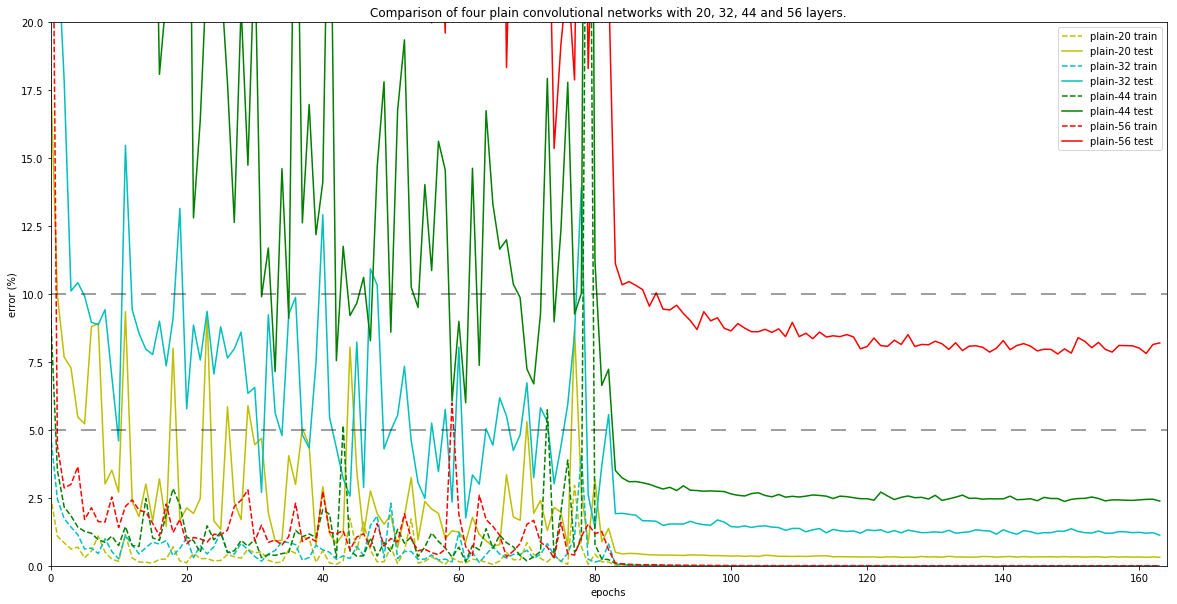

In [14]:
ns  = [3, 5, 7, 9]
clr = ['y', 'c', 'g', 'r']


plainnet_dfs = [pd.read_csv(f'results/plainnet{6*n+2}.csv') for n in ns]
fig = plt.figure(figsize=(20, 10))
plt.axis([0, 164, 0, 20])


for i in range(len(ns)):
    plt.plot(plainnet_dfs[i]['epoch'], plainnet_dfs[i]['train_err']*100, f'{clr[i]}--',
             label=f'plain-{6*ns[i]+2} train')
    plt.plot(plainnet_dfs[i]['epoch'], plainnet_dfs[i]['test_err']*100, f'{clr[i]}',
             label=f'plain-{6*ns[i]+2} test')

plt.title('Comparison of four plain convolutional networks with 20, 32, 44 and 56 layers.')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('error (%)')
plt.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
plt.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));

In [15]:
bests = [df[df['test_err'] == df['test_err'].min()].iloc[0] for df in plainnet_dfs]
bests_df= pd.concat(bests, axis=1).T
bests_df['model'] = ['PlainNet20', 'PlainNet32', 'PlainNet44', 'PlainNet56']
display(bests_df[['model', 'test_err']])

,model,test_err
122,PlainNet20,0.003125
163,PlainNet32,0.011250
149,PlainNet44,0.023688
148,PlainNet56,0.077938


### Resnet

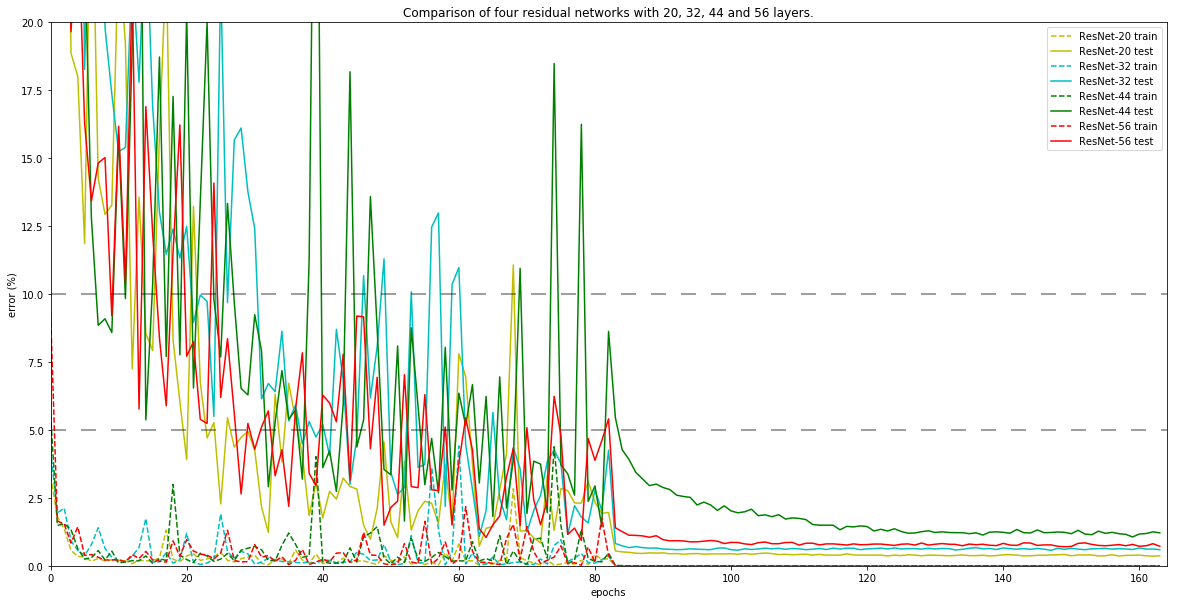

In [16]:
ns  = [3, 5, 7, 9]
clr = ['y', 'c', 'g', 'r']

resnet_dfs = [pd.read_csv(f'results/resnet{6*n+2}.csv') for n in ns]
fig = plt.figure(figsize=(20, 10))
plt.axis([0, 164, 0, 20])


for i in range(len(ns)):
    plt.plot(resnet_dfs[i]['epoch'], resnet_dfs[i]['train_err']*100, f'{clr[i]}--',
             label=f'ResNet-{6*ns[i]+2} train')
    plt.plot(resnet_dfs[i]['epoch'], resnet_dfs[i]['test_err']*100, f'{clr[i]}',
             label=f'ResNet-{6*ns[i]+2} test')

plt.title('Comparison of four residual networks with 20, 32, 44 and 56 layers.')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('error (%)')
plt.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
plt.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));

In [17]:
bests = [df[df['test_err'] == df['test_err'].min()].iloc[0] for df in resnet_dfs]
bests_df= pd.concat(bests, axis=1).T
bests_df['model'] = ['ResNet20', 'ResNet32', 'ResNet44', 'ResNet56']
display(bests_df[['model', 'test_err']])


,model,test_err
162,ResNet20,0.003563
147,ResNet32,0.005687
159,ResNet44,0.010625
149,ResNet56,0.007000


## Side-by-side plot

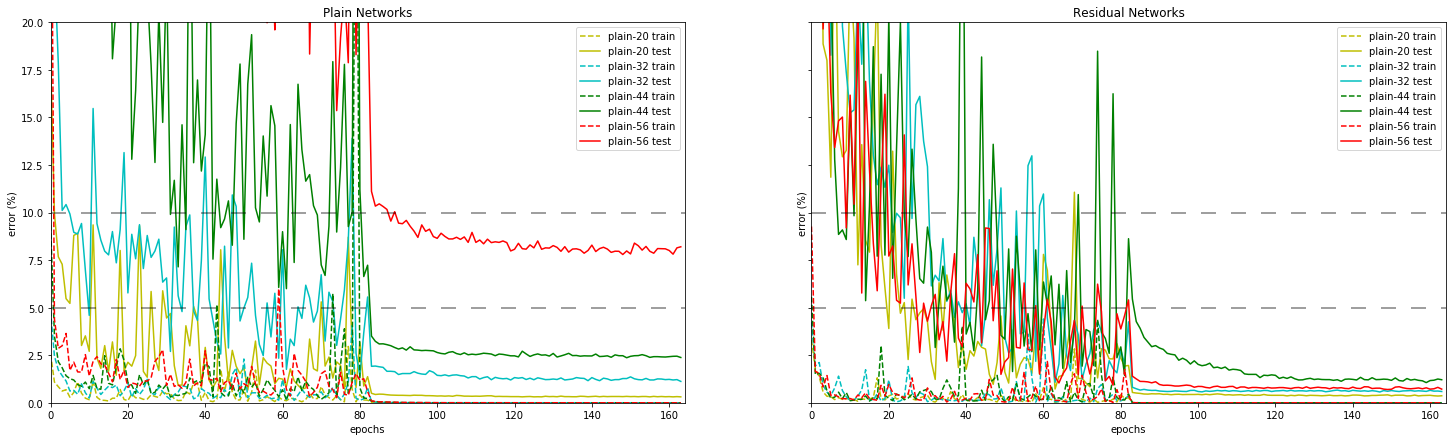

In [18]:
ns  = [3, 5, 7, 9]
clr = ['y', 'c', 'g', 'r']


f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25, 7))

plainnet_dfs = [pd.read_csv(f'results/plainnet{6*n+2}.csv') for n in ns]
resnet_dfs = [pd.read_csv(f'results/resnet{6*n+2}.csv') for n in ns]

def plot_results(dfs, ax, title):
    ax.axis([0, 164, 0, 20])
    
    for i in range(len(ns)):
        ax.plot(dfs[i]['epoch'], dfs[i]['train_err']*100, f'{clr[i]}--',
                 label=f'plain-{6*ns[i]+2} train')
        ax.plot(dfs[i]['epoch'], dfs[i]['test_err']*100, f'{clr[i]}',
                 label=f'plain-{6*ns[i]+2} test')
    
    ax.set_title(title)
    ax.legend(loc='bottom left')
    ax.set_xlabel('epochs')
    ax.set_ylabel('error (%)')
    ax.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
    ax.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));
    
plot_results(plainnet_dfs, ax1, 'Plain Networks')
plot_results(resnet_dfs, ax2, 'Residual Networks')

In [19]:
!python3 --version

Python 3.6.8 :: Anaconda, Inc.
